## Problem Statement:

### How good is Kholi against CSK in M.Chinnaswamy Stadium when CSK playing with 3 spinners?

- (Apart from career statistics (matches/runs/avg/sr) What information can be derived from a player’s historic data?)
- Strengths & Weaknesses against bowling types
- His contribution to team’s win
- Performance against specific opposition
- Performance in specific venues


### Topics Involved:
- Player Analysis
    - Player-level statistics --- (runs/sr/RPI/BPB)
    - Type of player --- (anchor/strike-rotator/hitter)
    - Performance in diff phases of play --- (PP/Middle/Death)
    - Performance by innings --- (Bat 1st/2nd)
- Team Analysis
    - Performance against oppositions --- (RPI/SR)
- Venue Analysis
    - Performance in venues
    - Toss factor
    - Venue type --- (runrates, wickets, ..)

In [1]:
import math
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

import matplotlib.pyplot as plt

In [51]:
deliveries = pd.read_csv('deliveries_updated_mens_ipl.csv')
matches = pd.read_csv('matches_updated_mens_ipl.csv')

In [52]:
deliveries.head()

,matchId,inning,over_ball,over,ball,batting_team,bowling_team,batsman,non_striker,bowler,batsman_runs,extras,isWide,isNoBall,Byes,LegByes,Penalty,dismissal_kind,player_dismissed
0,1082591,1,0.1,0,1,Sunrisers Hyderabad,Royal Challengers Bangalore,DA Warner,S Dhawan,TS Mills,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082591,1,0.2,0,2,Sunrisers Hyderabad,Royal Challengers Bangalore,DA Warner,S Dhawan,TS Mills,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082591,1,0.3,0,3,Sunrisers Hyderabad,Royal Challengers Bangalore,DA Warner,S Dhawan,TS Mills,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1082591,1,0.4,0,4,Sunrisers Hyderabad,Royal Challengers Bangalore,DA Warner,S Dhawan,TS Mills,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1082591,1,0.5,0,5,Sunrisers Hyderabad,Royal Challengers Bangalore,DA Warner,S Dhawan,TS Mills,0,2,2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
matches.head(2)

,outcome,event,date,gender,reserve_umpire,team1,toss_winner,umpire2,match_referee,season,team2,winner_runs,balls_per_over,player_of_match,date1,neutralvenue,venue,method,toss_decision,city,tv_umpire,date2,winner,umpire1,match_number,eliminator,winner_wickets,matchId
0,NaN,Indian Premier League,2017-04-05,male,N Pandit,Sunrisers Hyderabad,Royal Challengers Bangalore,NJ Llong,J Srinath,2017,Royal Challengers Bangalore,35.0,6,Yuvraj Singh,NaN,NaN,"Rajiv Gandhi International Stadium, Uppal",NaN,field,Hyderabad,A Deshmukh,NaN,Sunrisers Hyderabad,AY Dandekar,1.0,NaN,NaN,1082591
1,NaN,Indian Premier League,2017-04-06,male,Navdeep Singh,Rising Pune Supergiant,Rising Pune Supergiant,S Ravi,M Nayyar,2017,Mumbai Indians,NaN,6,SPD Smith,NaN,NaN,Maharashtra Cricket Association Stadium,NaN,field,Pune,VK Sharma,NaN,Rising Pune Supergiant,A Nand Kishore,2.0,NaN,7.0,1082592


## Part 1: Player Statistics

### 1.1 : Extract player-level statistics
### 1.2 : Determine player type from the above stats

In [5]:
def balls_per_dismissal(balls, dismissals):
    if dismissals > 0:
        return balls/dismissals
    else:
        return balls/1 
    
def balls_per_boundary(balls, boundaries):
    if boundaries > 0:
        return balls/boundaries
    else:
        return balls/1 

def playerStatistics(df):
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'matchId':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['matchId'].count()).reset_index().rename(columns = {'matchId':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [54]:
df = playerStatistics(deliveries)

In [55]:
df.head()

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,23,280,196,15,61,83,20,1,16,15,142.857143,12.173913,13.066667,6.322581
1,A Badoni,11,161,139,9,57,53,11,0,11,7,115.827338,14.636364,15.444444,7.722222
2,A Chandila,2,4,7,1,3,4,0,0,0,0,57.142857,2.000000,7.000000,7.000000
3,A Chopra,6,53,75,5,45,21,2,0,7,0,70.666667,8.833333,15.000000,10.714286
4,A Choudhary,3,25,20,2,4,13,1,0,1,1,125.000000,8.333333,10.000000,10.000000


### 1.3 : Performance in different phases of play

In [8]:
def phase(over):
    if over <= 6:
        return 'Powerplay'
    elif over <= 15:
        return 'Middle'
    else:
        return 'Death'

In [56]:
deliveries['phase'] = deliveries['over'].apply(lambda x: phase(x))

In [10]:
def phasesOfplay(df, current_phase):
    
    df = df[df.phase == current_phase]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'matchId'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'matchId':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['matchId'].count()).reset_index().rename(columns = {'matchId':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [57]:
pp_df = phasesOfplay(deliveries, 'Powerplay')
mid_df = phasesOfplay(deliveries, 'Middle')
dth_df = phasesOfplay(deliveries, 'Death')

In [58]:
pp_df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,1,5,7,1,5,1,0,0,1,0,71.428571,5.0,7.0,7.0
1,A Badoni,2,2,9,1,7,2,0,0,0,0,22.222222,1.0,9.0,9.0


In [59]:
mid_df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,8,83,60,3,21,23,7,0,4,5,138.333333,10.375,20.000000,6.666667
1,A Badoni,8,75,73,3,31,29,5,0,6,2,102.739726,9.375,24.333333,9.125000


In [60]:
dth_df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,19,192,129,11,35,59,13,1,11,10,148.837209,10.105263,11.727273,6.142857
1,A Badoni,7,84,57,5,19,22,6,0,5,5,147.368421,12.000000,11.400000,5.700000


### 1.4 : Performance by Bat 1st/2nd

In [15]:
def ByInning(df, current_inning):
    
    df = df[df.inning == current_inning]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'matchId'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'matchId':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['matchId'].count()).reset_index().rename(columns = {'matchId':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [61]:
ing1_df = ByInning(deliveries, 1)
ing2_df = ByInning(deliveries, 2)

In [62]:
ing1_df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,13,166,115,7,32,53,13,1,6,10,144.347826,12.769231,16.428571,7.187500
1,A Badoni,5,106,89,5,32,38,8,0,7,4,119.101124,21.200000,17.800000,8.090909


In [63]:
ing2_df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,10,114,81,8,29,30,7,0,10,5,140.740741,11.400000,10.125,5.400000
1,A Badoni,6,55,50,4,25,15,3,0,4,3,110.000000,9.166667,12.500,7.142857


In [64]:
comp = ing1_df[['batsman', 'RPI']].merge(ing2_df[['batsman', 'RPI']], on = 'batsman', how = 'inner').rename(columns = {'RPI_x':'1st_RPI', 'RPI_y':'2nd_RPI' })

In [65]:
comp.head(2)

,batsman,1st_RPI,2nd_RPI
0,A Ashish Reddy,12.769231,11.400000
1,A Badoni,21.200000,9.166667


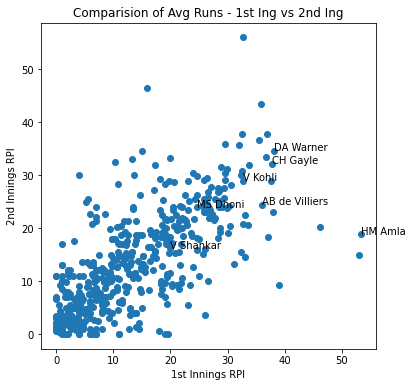

In [66]:
plt.figure(figsize = (6, 6))
plt.scatter(comp['1st_RPI'], comp['2nd_RPI'] )
plt.xlabel('1st Innings RPI')
plt.ylabel('2nd Innings RPI')
plt.title('Comparision of Avg Runs - 1st Ing vs 2nd Ing')

annotations=list(comp['batsman'])
selected_players = ['CH Gayle', 'V Kohli', 'AB de Villiers', 'DA Warner', 'V Shankar', 'HM Amla', 'MS Dhoni']

for i, label in enumerate(annotations):
    if label in selected_players:
        plt.annotate(label, (comp['1st_RPI'][i], comp['2nd_RPI'][i]))
    
    
plt.show()

In [67]:
comp[comp['1st_RPI'] > 50]

,batsman,1st_RPI,2nd_RPI
152,HM Amla,53.25,18.875
216,Kamran Akmal,53.00,15.000


## Part 2 - Performance by opposition:

In [23]:
def ByOpposition(df, current_opposition):
    
    df = df[df.bowling_team == current_opposition]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'matchId'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'matchId':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['matchId'].count()).reset_index().rename(columns = {'matchId':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    # StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    # runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    # balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    # balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [68]:
ByOpposition(deliveries, 'Royal Challengers Bangalore').head(3)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,5,55,42,4,15,19,2,0,2,4,130.952381,11.0,10.5,7.0
1,A Badoni,1,13,13,1,7,3,1,0,2,0,100.000000,13.0,13.0,6.5
2,A Chandila,1,4,6,0,2,4,0,0,0,0,66.666667,4.0,6.0,6.0


In [69]:
deliveries.head(2)

,matchId,inning,over_ball,over,ball,batting_team,bowling_team,batsman,non_striker,bowler,batsman_runs,extras,isWide,isNoBall,Byes,LegByes,Penalty,dismissal_kind,player_dismissed,isDot,isOne,isTwo,isThree,isFour,isSix,phase
0,1082591,1,0.1,0,1,Sunrisers Hyderabad,Royal Challengers Bangalore,DA Warner,S Dhawan,TS Mills,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,Powerplay
1,1082591,1,0.2,0,2,Sunrisers Hyderabad,Royal Challengers Bangalore,DA Warner,S Dhawan,TS Mills,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,Powerplay


## Kohli's performance against all teams:

In [70]:
selected_player = 'V Kohli'

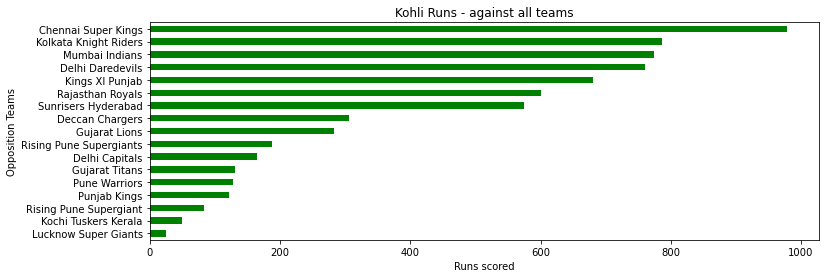

In [71]:
plt.figure(figsize = (12, 4))
deliveries[deliveries.batsman == selected_player].groupby(['bowling_team'])['batsman_runs'].sum().sort_values().plot(kind = 'barh', color = 'g')
plt.title('Kohli Runs - against all teams')
plt.xlabel('Runs scored')
plt.ylabel('Opposition Teams')
plt.show()

## Part 3 : Venue Analysis

In [28]:
def wintoss_winmatch(toss_decision, team1, team2, winner):
    if toss_decision == 'field':
        if team2 == winner:
            return True
        else:
            return False
        
    else:
        if team1 == winner:
            return True
        else:
            return False


In [72]:
matches['wintoss_winmatch'] = matches.apply(lambda x: wintoss_winmatch(x['toss_decision'], x['team1'], x['team2'], x['winner']), axis = 1)

In [73]:
matches[['season', 'team1', 'team2', 'wintoss_winmatch']].head()

,season,team1,team2,wintoss_winmatch
0,2017,Sunrisers Hyderabad,Royal Challengers Bangalore,False
1,2017,Rising Pune Supergiant,Mumbai Indians,False
2,2017,Gujarat Lions,Kolkata Knight Riders,True
3,2017,Kings XI Punjab,Rising Pune Supergiant,False
4,2017,Royal Challengers Bangalore,Delhi Daredevils,True


In [74]:
print('% of wintoss-winmatch =', 100*len(matches[matches.wintoss_winmatch == 1])/len(matches))

% of wintoss-winmatch = 52.73684210526316


In [32]:
def isOut(player_dismissed):
    try:
        x = math.isnan(player_dismissed)
        return 0
    except:
        return 1

def venueAnalysis(mdf, df):
    
    runs = pd.DataFrame(df.groupby(['matchId', 'inning'])['batsman_runs'].sum().reset_index())
    runs['Id_Ing'] = runs.apply(lambda x: str(x['matchId']) + '-' + str(x['inning']), axis = 1)
    
    balls = pd.DataFrame(df.groupby(['matchId', 'inning'])['batsman_runs'].count().reset_index()).rename(columns = {'batsman_runs':'total_balls'})
    balls['Id_Ing'] = balls.apply(lambda x: str(x['matchId']) + '-' + str(x['inning']), axis = 1)
    
    df['isOut'] = df['player_dismissed'].apply(lambda x: isOut(x))
    outs = pd.DataFrame(df.groupby(['matchId', 'inning'])['isOut'].sum().reset_index()).rename(columns = {'isOut':'wickets'})
    outs['Id_Ing'] = outs.apply(lambda x: str(x['matchId']) + '-' + str(x['inning']), axis = 1)
    
    df = pd.merge(runs, balls[['Id_Ing', 'total_balls']], on = 'Id_Ing').merge(outs[['Id_Ing', 'wickets']], on = 'Id_Ing')
    
    mdf = mdf.rename(columns = {'matchId':'matchId'})
    df = pd.merge(df, mdf[['matchId', 'venue']], on = 'matchId')
    df = df[['matchId', 'venue', 'inning', 'batsman_runs', 'total_balls', 'wickets']]
    
    return df

In [75]:
ven_df = venueAnalysis(matches, deliveries)

In [76]:
ven_df.head()

,matchId,venue,inning,batsman_runs,total_balls,wickets
0,335982,M Chinnaswamy Stadium,1,205,124,3
1,335982,M Chinnaswamy Stadium,2,63,101,10
2,335983,"Punjab Cricket Association Stadium, Mohali",1,234,124,5
3,335983,"Punjab Cricket Association Stadium, Mohali",2,196,124,4
4,335984,Feroz Shah Kotla,1,122,122,8


In [77]:
pd.DataFrame(ven_df.groupby('venue')['batsman_runs'].mean().sort_values(ascending = False)).rename(columns = {'batsman_runs':'Avg_Runs'}).reset_index().head(10)

,venue,Avg_Runs
0,"Eden Gardens, Kolkata",180.750000
1,"Arun Jaitley Stadium, Delhi",179.375000
2,Punjab Cricket Association IS Bindra Stadium,166.700000
3,M.Chinnaswamy Stadium,163.200000
4,Brabourne Stadium,163.150000
5,"Brabourne Stadium, Mumbai",161.676471
6,"Wankhede Stadium, Mumbai",156.919355
7,Barabati Stadium,156.785714
8,"Punjab Cricket Association IS Bindra Stadium, Mohali",155.272727
9,"Dr DY Patil Sports Academy, Mumbai",154.975000


In [36]:
def ByVenue(df, current_venue):
    
    df = df[df.venue == current_venue]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'matchId'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'matchId':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['matchId'].count()).reset_index().rename(columns = {'matchId':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [78]:
matches.rename(columns = {'id':'matchId'}, inplace = True)

In [79]:
combined_data = deliveries.merge(matches[['matchId', 'venue']], on = 'matchId', how = 'left')

In [80]:
combined_data.head(2)

,matchId,inning,over_ball,over,ball,batting_team,bowling_team,batsman,non_striker,bowler,batsman_runs,extras,isWide,isNoBall,Byes,LegByes,Penalty,dismissal_kind,player_dismissed,isDot,isOne,isTwo,isThree,isFour,isSix,phase,isOut,venue
0,1082591,1,0.1,0,1,Sunrisers Hyderabad,Royal Challengers Bangalore,DA Warner,S Dhawan,TS Mills,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,Powerplay,0,"Rajiv Gandhi International Stadium, Uppal"
1,1082591,1,0.2,0,2,Sunrisers Hyderabad,Royal Challengers Bangalore,DA Warner,S Dhawan,TS Mills,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,Powerplay,0,"Rajiv Gandhi International Stadium, Uppal"


In [81]:
current_venue = 'M.Chinnaswamy Stadium'

In [82]:
df = ByVenue(combined_data, current_venue)

In [83]:
df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Mishra,1,8,14,0,7,6,1,0,0,0,57.142857,8.000000,14.000000,14.000000
1,AB de Villiers,12,572,335,9,109,123,19,1,45,38,170.746269,47.666667,37.222222,4.036145


### Problem Statement: How good is Kholi against CSK in M.Chinnaswamy Stadium when CSK playing 3 spinners?

### Filters in our problem statement:
- Stadium = 'M.Chinnaswamy Stadium'
- Phase = 'Middle Overs'
- Oppostion Team = 'Chennai Super Kings'

In [43]:
def ByCustom(df, current_venue, current_phase, current_opposition):
    
    df = df[df.venue == current_venue]
    df = df[df.phase == current_phase]
    df = df[df.bowling_team == current_opposition]
    
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'matchId'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'matchId':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['matchId'].count()).reset_index().rename(columns = {'matchId':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [84]:
df = ByCustom(combined_data, 'M.Chinnaswamy Stadium', 'Middle', 'Chennai Super Kings')

In [85]:
df['dot_percentage'] = df.apply(lambda x: x['dots']/x['balls'], axis = 1)

In [86]:
df.head()

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB,dot_percentage
0,AB de Villiers,1,45,20,1,4,9,1,0,1,5,225.0,45.0,20.0,3.333333,0.20
1,AD Nath,1,24,20,1,5,12,1,0,1,1,120.0,24.0,20.0,10.000000,0.25
2,C de Grandhomme,1,0,1,0,1,0,0,0,0,0,0.0,0.0,1.0,1.000000,1.00
3,CJ Anderson,1,2,8,1,6,2,0,0,0,0,25.0,2.0,8.0,8.000000,0.75
4,MM Ali,1,0,2,0,2,0,0,0,0,0,0.0,0.0,2.0,2.000000,1.00


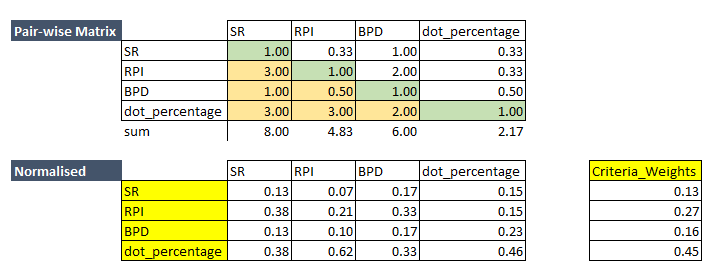

In [87]:
wt_sr, wt_rpi, wt_bpd, wt_dot_percentage = 0.13, 0.27, 0.16, 0.45

In [48]:
#df = df[df.innings >= 2 ]

In [88]:
df.head(20)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB,dot_percentage
0,AB de Villiers,1,45,20,1,4,9,1,0,1,5,225.000000,45.0,20.0,3.333333,0.200000
1,AD Nath,1,24,20,1,5,12,1,0,1,1,120.000000,24.0,20.0,10.000000,0.250000
2,C de Grandhomme,1,0,1,0,1,0,0,0,0,0,0.000000,0.0,1.0,1.000000,1.000000
3,CJ Anderson,1,2,8,1,6,2,0,0,0,0,25.000000,2.0,8.0,8.000000,0.750000
4,MM Ali,1,0,2,0,2,0,0,0,0,0,0.000000,0.0,2.0,2.000000,1.000000
5,MP Stoinis,1,12,10,0,4,4,1,0,0,1,120.000000,12.0,10.0,10.000000,0.400000
6,Mandeep Singh,1,11,5,0,2,1,0,0,1,1,220.000000,11.0,5.0,2.500000,0.400000
7,PA Patel,1,30,22,1,4,14,1,0,2,1,136.363636,30.0,22.0,7.333333,0.181818
8,Q de Kock,1,31,21,1,7,7,4,0,1,2,147.619048,31.0,21.0,7.000000,0.333333


### Calculation - Normalizing all values to same dimensions

In [89]:
#step1: square of all values
df['calc_SR'] = df['SR'].apply(lambda x: x*x) 
df['calc_RPI'] = df['RPI'].apply(lambda x: x*x) 
df['calc_BPD'] = df['BPD'].apply(lambda x: x*x) 
df['calc_dot_percentage'] = df['dot_percentage'].apply(lambda x: x*x)

sq_sr, sq_rpi, sq_bpd, sq_dot_percentage = np.sqrt(df[['calc_SR','calc_RPI', 'calc_BPD', 'calc_dot_percentage']].sum(axis = 0))

df['calc_SR'] = df['calc_SR'].apply(lambda x: x/sq_sr) 
df['calc_RPI'] = df['calc_RPI'].apply(lambda x: x/sq_rpi) 
df['calc_BPD'] = df['calc_BPD'].apply(lambda x: x/sq_bpd) 
df['calc_dot_percentage'] = df['calc_dot_percentage'].apply(lambda x: x/sq_dot_percentage)

df['calc_SR'] = df['calc_SR'].apply(lambda x: x*wt_sr) 
df['calc_RPI'] = df['calc_RPI'].apply(lambda x: x*wt_rpi) 
df['calc_BPD'] = df['calc_BPD'].apply(lambda x: x*wt_bpd) 
df['calc_dot_percentage'] = df['calc_dot_percentage'].apply(lambda x: x*wt_dot_percentage)

best_sr, worst_sr = max(df['calc_SR']), min(df['calc_SR'])
best_rpi, worst_rpi = max(df['calc_RPI']), min(df['calc_RPI'])
best_bpd, worst_bpd = max(df['calc_BPD']), min(df['calc_BPD'])
best_dot_percentage, worst_dot_percentage = min(df['calc_dot_percentage']), max(df['calc_dot_percentage'])

###  Calculation - Comparision against the best & worst values

In [90]:
df['dev_best_SR'] = df['calc_SR'].apply(lambda x: (x-best_sr)*(x-best_sr)) 
df['dev_best_RPI'] = df['calc_RPI'].apply(lambda x: (x-best_rpi)*(x-best_rpi)) 
df['dev_best_BPD'] = df['calc_BPD'].apply(lambda x: (x-best_bpd)*(x-best_bpd)) 
df['dev_best_dot_percentage'] = df['calc_dot_percentage'].apply(lambda x: (x-best_dot_percentage)*(x-best_dot_percentage))

df['dev_best_sqrt'] = df.apply(lambda x: x['dev_best_SR'] + x['dev_best_RPI'] + x['dev_best_BPD'] + x['dev_best_dot_percentage'], axis = 1) 

df['dev_worst_SR'] = df['calc_SR'].apply(lambda x: (x-worst_sr)*(x-worst_sr)) 
df['dev_worst_RPI'] = df['calc_RPI'].apply(lambda x: (x-worst_rpi)*(x-worst_rpi)) 
df['dev_worst_BPD'] = df['calc_BPD'].apply(lambda x: (x-worst_bpd)*(x-worst_bpd)) 
df['dev_worst_dot_percentage'] = df['calc_dot_percentage'].apply(lambda x: (x-worst_dot_percentage)*(x-worst_dot_percentage))

df['dev_worst_sqrt'] = df.apply(lambda x: x['dev_worst_SR'] + x['dev_worst_RPI'] + x['dev_worst_BPD'] + x['dev_worst_dot_percentage'], axis = 1) 

### Final Step - Overall score for each player ( values from 0 - 1)

In [91]:
df['score'] = df.apply(lambda x: x['dev_worst_sqrt']/(x['dev_worst_sqrt'] + x['dev_best_sqrt']), axis = 1)

In [92]:
df[['batsman', 'score']].head()

,batsman,score
0,AB de Villiers,9.997077e-01
1,AD Nath,1.462046e-01
2,C de Grandhomme,0.000000e+00
3,CJ Anderson,3.316308e-04
4,MM Ali,3.718740e-07


### End Result: Top players for our required role

In [93]:
df[[ 'batsman','innings', 'runs', 'balls', 'dismissals', 'dot_percentage', 'score']].sort_values(['score'], ascending = False).reset_index(drop = True).head(25)

,batsman,innings,runs,balls,dismissals,dot_percentage,score
0,AB de Villiers,1,45,20,1,0.200000,9.997077e-01
1,Mandeep Singh,1,11,5,0,0.400000,7.987000e-01
2,Q de Kock,1,31,21,1,0.333333,3.900835e-01
3,PA Patel,1,30,22,1,0.181818,2.914618e-01
4,AD Nath,1,24,20,1,0.250000,1.462046e-01
5,MP Stoinis,1,12,10,0,0.400000,1.016396e-01
6,CJ Anderson,1,2,8,1,0.750000,3.316308e-04
7,MM Ali,1,0,2,0,1.000000,3.718740e-07
8,C de Grandhomme,1,0,1,0,1.000000,0.000000e+00
